# Daily Calendar View
---

In [1]:
# Import necessary libraries
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
import datetime
from datetime import date
import glob
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import calplot
from itables import init_notebook_mode, show
import itables.options as opt

# Initialize itables options
opt.dom = "tpir"
opt.style = "table-layout:auto;width:auto"
init_notebook_mode(all_interactive=True, connected=True)

# Register a custom cell magic for markdown
@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))

# Configure logging and warnings
logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")

# Configure pandas display options
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)


In [2]:
def get_nested_value(entry, keys, default='Missing_Data'):
    try:
        for key in keys:
            entry = entry[key]
        return entry
    except (KeyError, IndexError):
        return default

row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            new_row = {
                'CVE': get_nested_value(entry, ['cve', 'id']),
                'Published': get_nested_value(entry, ['cve', 'published']),
                'AttackVector': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackVector']),
                'AttackComplexity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackComplexity']),
                'PrivilegesRequired': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'privilegesRequired']),
                'UserInteraction': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'userInteraction']),
                'Scope': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'scope']),
                'ConfidentialityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'confidentialityImpact']),
                'IntegrityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'integrityImpact']),
                'AvailabilityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'availabilityImpact']),
                'BaseScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseScore'], '0.0'),
                'BaseSeverity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseSeverity']),
                'ExploitabilityScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'exploitabilityScore']),
                'ImpactScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'impactScore']),
                'CWE': get_nested_value(entry, ['cve', 'weaknesses', 0, 'description', 0, 'value']),
                'Description': get_nested_value(entry, ['cve', 'descriptions', 0, 'value'], ''),
                'Assigner': get_nested_value(entry, ['cve', 'sourceIdentifier']),
                'Tag': get_nested_value(entry, ['cve', 'cveTags', 0, 'tags'], np.nan),
                'Status': get_nested_value(entry, ['cve', 'vulnStatus'], '')
            }
            row_accumulator.append(new_row)

nvd = pd.DataFrame(row_accumulator)
nvd = nvd[~nvd.Status.str.contains('Rejected')]
nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan);
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
startdate = date(2000, 1, 1)
enddate  = date.today()
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days

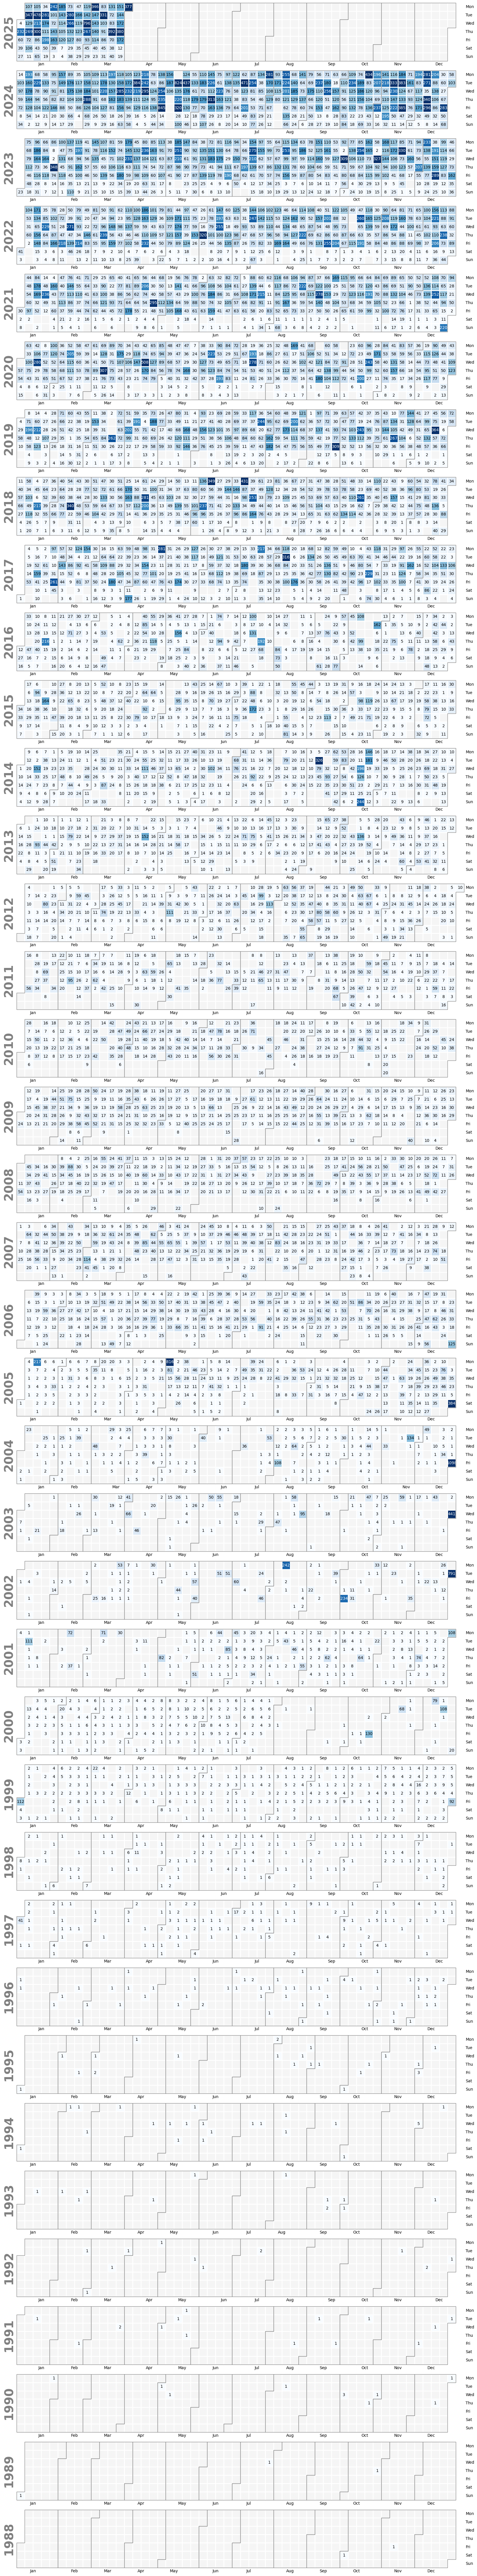

In [3]:
import calplot
import pandas as pd
import matplotlib.pyplot as plt

dfs = nvd['Published'].apply(lambda x: pd.to_datetime(x, errors='coerce', format='%Y/%m/%d'))
df = dfs.value_counts()
df = df.to_frame()
df.index = df.index.strftime('%m/%d/%Y')
df.index = pd.to_datetime(df.index, format='%m/%d/%Y')

# Function to determine text color based on background color intensity
def get_text_color(value, cmap, vmin, vmax):
    norm = plt.Normalize(vmin, vmax)
    rgba = cmap(norm(value))
    r, g, b, _ = rgba
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return 'white' if luminance < 0.5 else 'black'

# Improved calplot with better readability
cmap = plt.get_cmap('Blues')
vmin = 5
vmax = 300

fig, axes = calplot.calplot(
    df.T.squeeze(),
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    colorbar=False,
    dropzero=True,
    edgecolor="grey",
    textcolor="black",  # Initial text color
    textformat='{:.0f}',
    textfiller='',
    yearascending=False,
    figsize=(25, 90)
)

# Manually adjust text colors
for ax in axes.flatten():
    for text in ax.texts:
        try:
            value = float(text.get_text())
            text.set_color(get_text_color(value, cmap, vmin, vmax))
        except ValueError:
            # Handle non-numeric text values
            continue

plt.show()

In [4]:
Markdown(f"Total Number of CVEs: **{nvd['CVE'].count()}**<br />Average CVEs Per Day: **{per_day.round(2)}**<br />Average CVSS Score: **{nvd['BaseScore'].mean().round(2)}**")

Total Number of CVEs: **272780**<br />Average CVEs Per Day: **29.58**<br />Average CVSS Score: **6.9**

In [5]:
Markdown(f"This report is updated automatically every day, last generated on: **{datetime.datetime.now()}**")

This report is updated automatically every day, last generated on: **2025-04-01 04:14:24.659316**